# 2. 데이터 통합
## 1) 거리 기반 Feature 생성
- **BallTree 활용**:  
  - 교통 시설(버스, 지하철)과 편의시설의 좌표(위도, 경도)를 사용하여 BallTree 모델을 구축하고, 이를 통해 부동산(아파트) 위치와 각 시설 간의 최단 거리를 미터 단위로 계산합니다.
  - **생성 변수**:  
    - `dist_to_nearest_station_m`: 가장 가까운 교통 시설까지의 거리  
    - `dist_to_nearest_facility_m`: 가장 가까운 편의시설까지의 거리

## 2) 카테고리 Feature 인코딩 및 상호작용 변수
- **브랜드 추출**:  
  - `aptNm`(아파트 이름)에서 “더샵”, “푸르지오”, “힐스테이트”, “자이” 등 주요 브랜드를 정규표현식을 사용해 추출합니다.
- **클러스터링 (공구 분류)**:  
  - K-Means 클러스터링을 통해 아파트 단지의 대표 좌표(평균 위도, 경도)를 기준으로 10개의 클러스터(공구)를 도출하고, 이를 ‘zone’ 변수로 명명합니다.
- **원-핫 인코딩**:  
  - `zone` 및 `brand` 변수에 대해 원-핫 인코딩을 실시하여 모델링 시 범주형 변수의 영향을 반영합니다.
- **상호작용 변수**:  
  - `area_x_year`: 전용면적(`excluUseAr`)과 건축년도(`buildYear`)의 곱으로, 면적과 건축 시점이 매매가에 미치는 복합적인 영향을 고려합니다.
  - `area_x_floor`: 전용면적과 층(`floor`)의 곱으로, 면적과 층수 간 상호작용 효과를 분석합니다.
  - `boardings_per_facility`: 총 승차 인원 대비 편의시설 수를 산출하여, 교통 접근성과 생활 편의성이 시장 가격에 미치는 영향을 평가합니다.

## 3) 이벤트 및 경제 변수 반영
- **GTX-B 이슈 더미 변수**:  
  - GTX-B 관련 주요 이벤트(예: 예비타당성 조사, 실시설계 착수, 노선 확정 등)를 연월 단위로 기록하고, 해당 이벤트가 발생한 달에는 `gtx_issue` 변수에 1, 아니면 0을 부여합니다.
- **금리 데이터 통합**:  
  - 전처리한 기준금리(`Policy Rate`)와 국고채 금리(`Market Interest Rate`)를 연월 단위로 맞추어 병합함으로써, 거시경제 요인이 부동산 거래에 미치는 영향을 분석합니다.
- **주택 보급률 통합**:  
  - 인구 및 주택 수 데이터를 바탕으로 산출한 주택 보급률을 연도별로 계산하여, 공급 측면의 변수로 활용합니다.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('final_data_merged.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24116 entries, 0 to 24115
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sdNm                        24116 non-null  object 
 1   sggNm                       24116 non-null  object 
 2   umdNm                       24116 non-null  object 
 3   jibun                       24116 non-null  object 
 4   aptNm                       24116 non-null  object 
 5   excluUseAr                  24116 non-null  float64
 6   dealDate                    24116 non-null  object 
 7   dealAmount                  24116 non-null  float64
 8   pricePerpy                  24116 non-null  float64
 9   floor                       24116 non-null  int64  
 10  buildYear                   24116 non-null  int64  
 11  year_month                  24116 non-null  object 
 12  rent_conversion_rate        24116 non-null  float64
 13  full_address                241

In [ ]:
df.describe()

,excluUseAr,dealAmount,pricePerpy,floor,buildYear,rent_conversion_rate,latitude,longitude,log_dealAmount,dist_to_nearest_station_m,dist_to_nearest_facility_m,nearby_conveniences,nearby_transports,gtx_issue,Policy Rate,Market Interest Rate,HousingSupplyRate(%)
count,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000,24116.000000
mean,95.828213,62435.401601,2232.097741,16.273760,2012.570824,4.993054,37.390279,126.646777,11.004626,87.768484,270.626728,2.749337,2.820576,0.108849,1.664227,2.234572,89.108885
std,24.147060,17552.159742,687.211658,11.150542,4.491225,0.537633,0.011849,0.013825,0.271110,97.396753,264.662170,3.278678,1.684910,0.311456,1.051956,0.803433,11.092539
min,32.458400,28500.000000,860.215100,1.000000,2005.000000,4.400000,37.370494,126.612070,10.257694,0.148975,12.714007,0.000000,0.000000,0.000000,0.500000,1.420000,77.674983
25%,84.531700,50000.000000,1672.601600,7.000000,2009.000000,4.600000,37.381197,126.640907,10.819798,12.002612,109.602717,0.000000,1.000000,0.000000,1.250000,1.504000,80.525534
50%,84.957200,59500.000000,2084.014550,14.000000,2013.000000,4.700000,37.391041,126.648274,10.993748,26.850059,176.303824,2.000000,3.000000,0.000000,1.250000,1.787000,82.575215
75%,112.164300,72000.000000,2702.487425,23.000000,2016.000000,5.500000,37.397747,126.654911,11.184435,185.292284,319.696102,4.000000,4.000000,0.000000,1.750000,2.490000,105.031638
max,227.972000,128500.000000,5510.101900,59.000000,2024.000000,6.200000,37.415777,126.674967,11.763692,508.489412,1204.809410,19.000000,8.000000,1.000000,3.500000,4.267000,108.559489


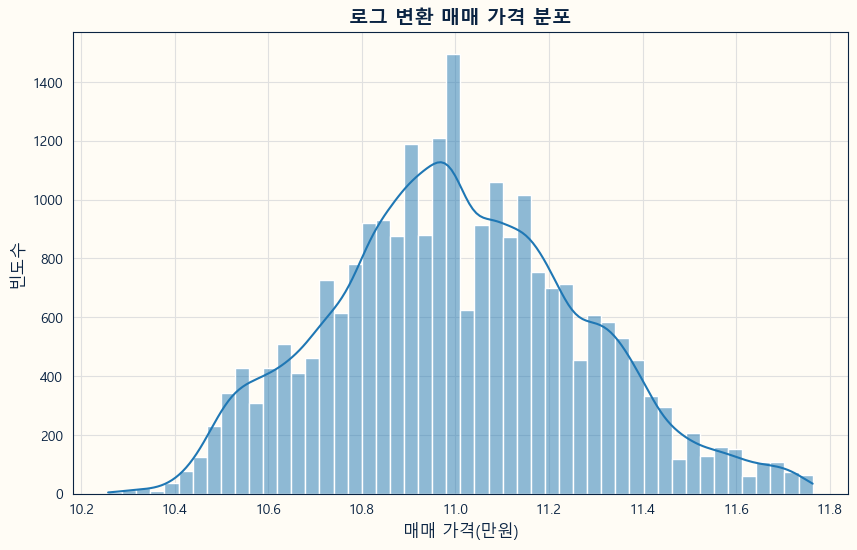

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['log_dealAmount'], bins=50, kde=True)
plt.xlabel('매매 가격(만원)')
plt.ylabel('빈도수')
plt.title('로그 변환 매매 가격 분포')
plt.show()


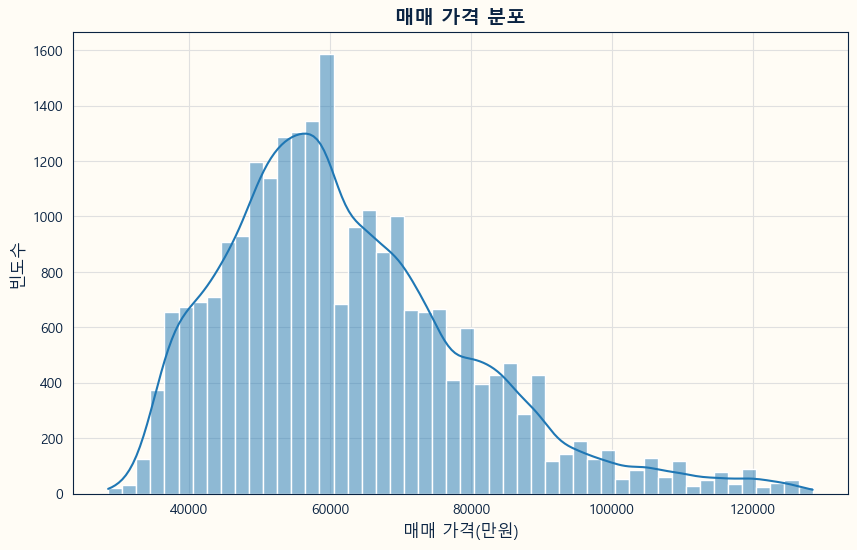

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['dealAmount'], bins=50, kde=True)
plt.xlabel('매매 가격(만원)')
plt.ylabel('빈도수')
plt.title('매매 가격 분포')
plt.show()


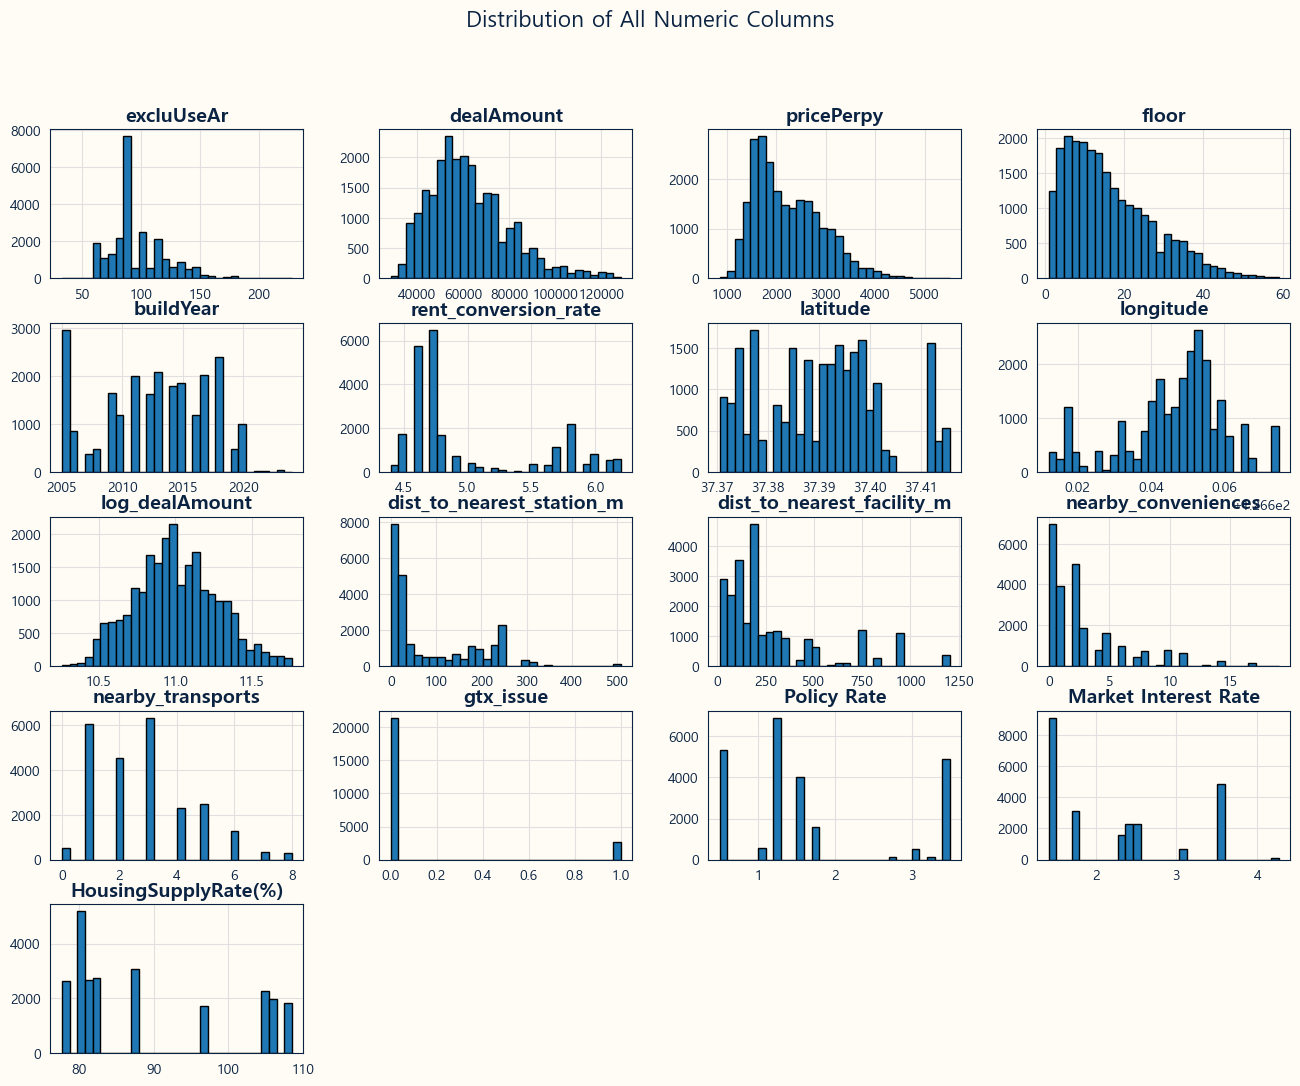

In [ ]:
# 숫자형 컬럼만 선택
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# 히스토그램 플롯
df[numeric_columns].hist(figsize=(16, 12), bins=30, edgecolor='black')

# 제목 설정
plt.suptitle("Distribution of All Numeric Columns", fontsize=16)
plt.show()

# 상관계수 히트맵

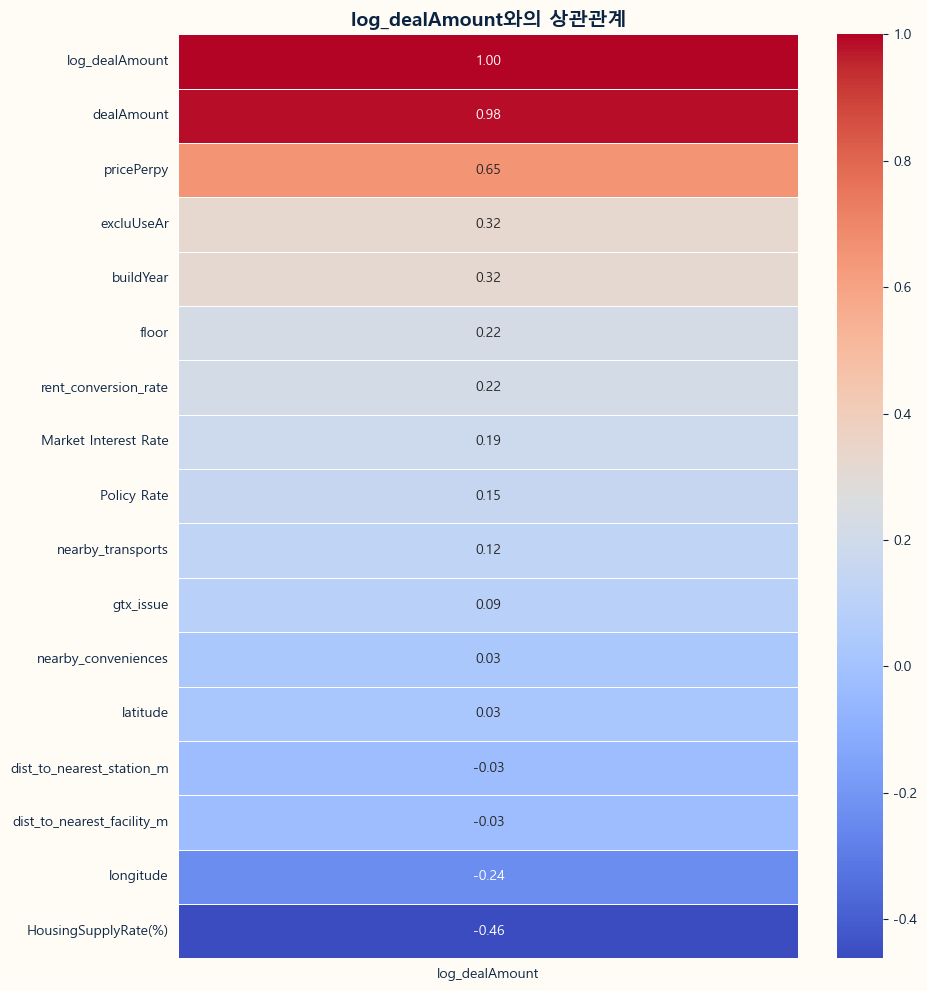

In [ ]:
# 수치형 컬럼 선택 (원핫 인코딩된 범주형 제외)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if not any([col.startswith('zone_'), col.startswith('brand_')])]

# 상관계수 행렬 계산
corr_matrix = df[numeric_cols].corr()

# log_dealAmount와의 상관계수만 추출
log_deal_corr = corr_matrix[['log_dealAmount']].sort_values(by='log_dealAmount', ascending=False)

# 상관계수 히트맵 시각화
plt.figure(figsize=(10, 12))
sns.heatmap(log_deal_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("log_dealAmount와의 상관관계")
plt.show()

## log_dealAmount와 수치형 변수 간 상관계수 히트맵
- 🔴 강한 양의 상관	pricePerpy
- 🟠 약한 양의 상관	excluUseAr, buildYear, floor, rent_conversion_rate, area_x_year, area_x_floor
- 🔵 약한 음의 상관	longitude
- 🔵 중간 수준 음의 상관	HousingSupplyRate(%)
- ⚪️ 거의 무관	gtx_issue, 편의시설, 거리 관련 변수들 등
- 공급률이 높을수록 가격은 낮은 경향
- 활용: 높은 상관 변수는 모델링에 우선 포함, 낮은 음의 상관도 주의 깊게 고려 (공급 많으면 가격 낮음) 

# 로그 가격 기준으로 범주형 변수 영향 분석

In [ ]:
df.columns

Index(['sdNm', 'sggNm', 'umdNm', 'jibun', 'aptNm', 'excluUseAr', 'dealDate',
       'dealAmount', 'pricePerpy', 'floor', 'buildYear', 'year_month',
       'rent_conversion_rate', 'full_address', 'latitude', 'longitude',
       'log_dealAmount', 'dist_to_nearest_station_m',
       'dist_to_nearest_facility_m', 'nearby_conveniences',
       'nearby_transports', 'zone_zone 1', 'zone_zone 10', 'zone_zone 2',
       'zone_zone 3', 'zone_zone 4', 'zone_zone 5', 'zone_zone 6',
       'zone_zone 7', 'zone_zone 8', 'zone_zone 9', 'brand_더샵', 'brand_자이',
       'brand_푸르지오', 'brand_힐스테이트', 'gtx_issue', 'Policy Rate',
       'Market Interest Rate', 'HousingSupplyRate(%)'],
      dtype='object')

In [ ]:
# zone 컬럼 되돌리기
zone_cols = [col for col in df.columns if col.startswith('zone_zone')]
df['zone'] = df[zone_cols].idxmax(axis=1).str.extract(r'zone_zone (\d+)')[0].astype(int)


In [ ]:
brand_cols = [col for col in df.columns if col.startswith('brand_')]
df['brand'] = df[brand_cols].idxmax(axis=1).str.replace('brand_', '', regex=False)

## 1. 공구(zone)별 로그 매매가 분포
- Zone 6, 9, 10은 평균 매매가가 높고, Zone 5, 2, 3은 비교적 낮음
- 중앙값과 박스 길이를 보면 가격 분포의 다양성(이질성) 도 다름. 특히 Zone 6, 9는 비교적 고가이며 안정적인 가격대를 보여줌.
- 활용: 공간별 가격차가 뚜렷하므로, 입지 기반 분석 또는 모델 피처로 zone을 활용하면 효과적.

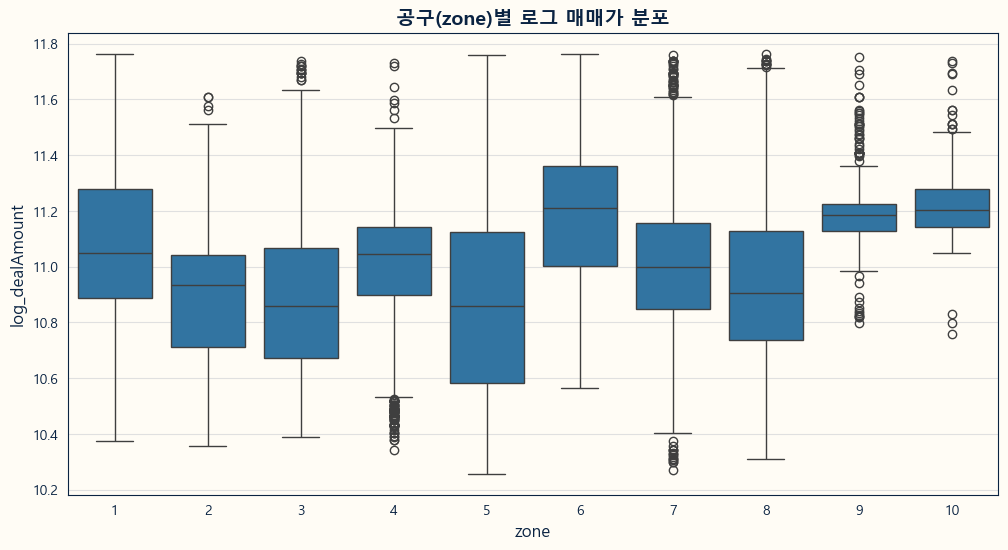

In [ ]:
# zone 별 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(x='zone', y='log_dealAmount', data=df)
plt.title('공구(zone)별 로그 매매가 분포')
plt.show()


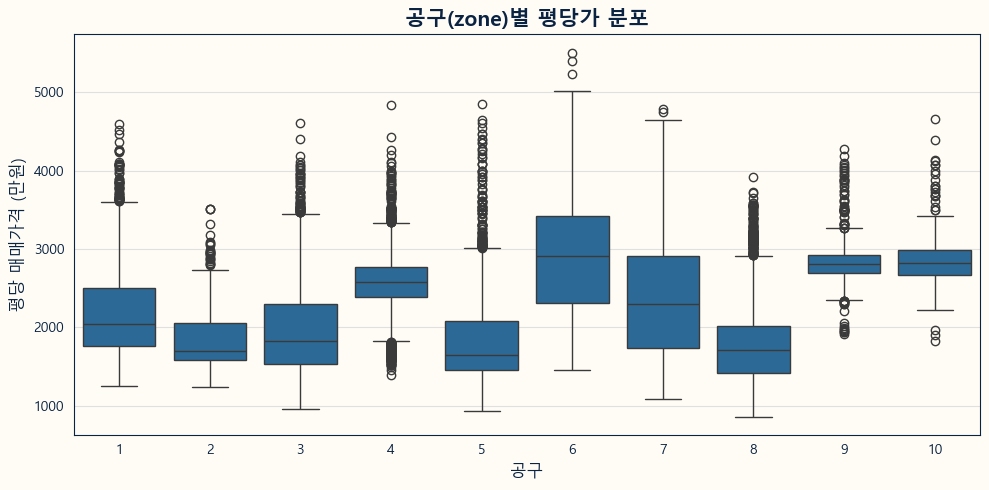

In [ ]:
apply_navistyle()
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='zone', y='pricePerpy', color=navipalette['ocean_blue'])
plt.title('공구(zone)별 평당가 분포', fontsize=15, weight='bold')
plt.xlabel('공구')
plt.ylabel('평당 매매가격 (만원)')
plt.tight_layout()
plt.show()


## 브랜드별 로그 매매가 분포
- 힐스테이트 > 푸르지오 > 자이 순으로 로그 매매가 중앙값이 높음.  
- 브랜드가 가격에 영향을 미치는 것을 보여줌.
- 활용: 브랜드를 프리미엄 지표로 모델링에 활용 가능.

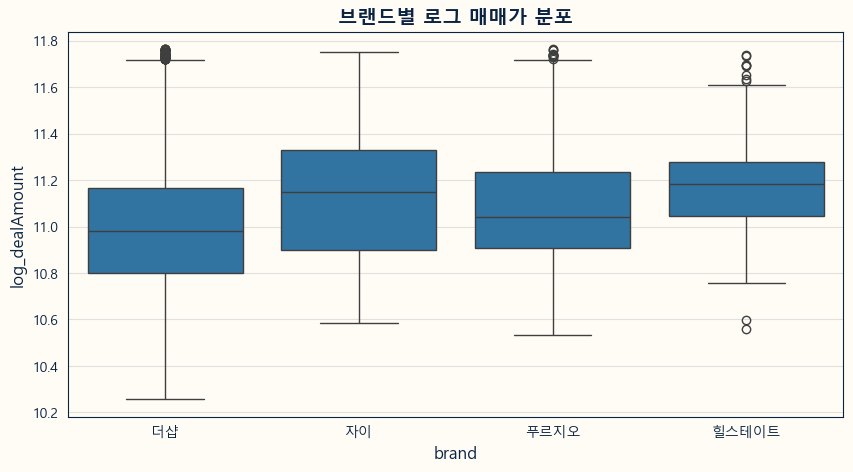

In [ ]:
# brand 별 박스플롯
plt.figure(figsize=(10, 5))
sns.boxplot(x='brand', y='log_dealAmount', data=df)
plt.title('브랜드별 로그 매매가 분포')
plt.show()


# GTX-B 이슈 유무에 따른 매매가 분포
- GTX 이슈가 있는 지역이 평균적으로 더 높은 매매가를 보임.
- 그러나 분포가 겹치긴 하므로 절대적인 효과보단 추세 기반 영향으로 해석 필요.
- 활용: gtx_issue는 정책·호재 기반 입지 가치를 측정하는 변수로 의미 있음.

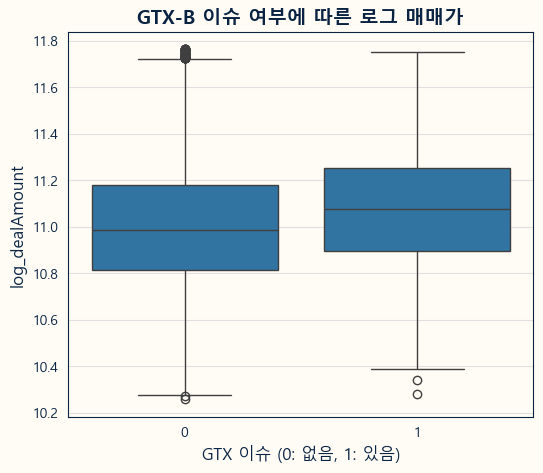

In [ ]:
# gtx 여부 박스플롯
plt.figure(figsize=(6, 5))
sns.boxplot(x='gtx_issue', y='log_dealAmount', data=df)
plt.title('GTX-B 이슈 여부에 따른 로그 매매가')
plt.xlabel('GTX 이슈 (0: 없음, 1: 있음)')
plt.show()

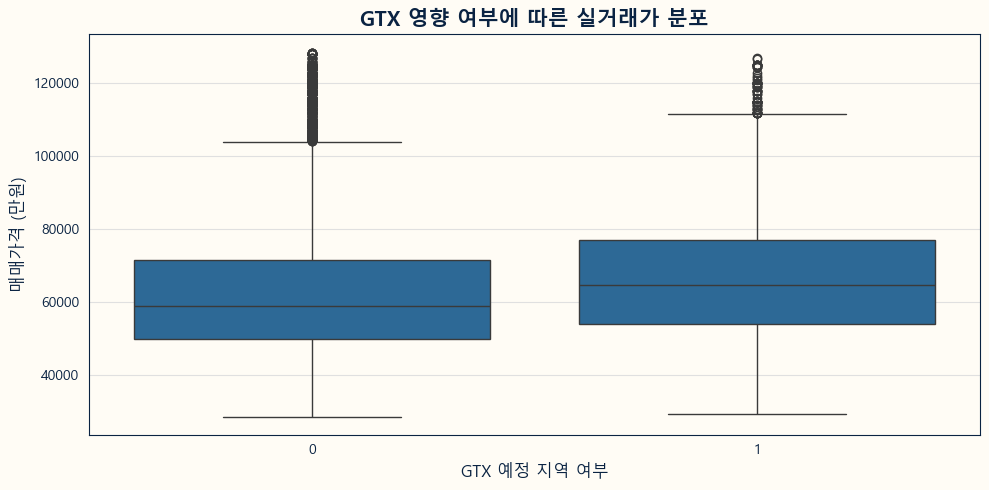

In [ ]:
apply_navistyle()
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='gtx_issue', y='dealAmount', color=navipalette['ocean_blue'])
plt.title('GTX 영향 여부에 따른 실거래가 분포', fontsize=15, weight='bold')
plt.xlabel('GTX 예정 지역 여부')
plt.ylabel('매매가격 (만원)')
plt.tight_layout()
plt.show()


In [ ]:
# zone 관련 컬럼명만 찾아서 바꾸기
df.rename(columns={col: col.replace('zone_zone ', 'zone_') for col in df.columns if col.startswith('zone_zone ')},
          inplace=True)

# 순서 정렬 및 평균선 추가
전체 평균선 또는 그룹 평균선을 박스플롯에 같이 표시하면 상대적 위치 판단이 쉬움

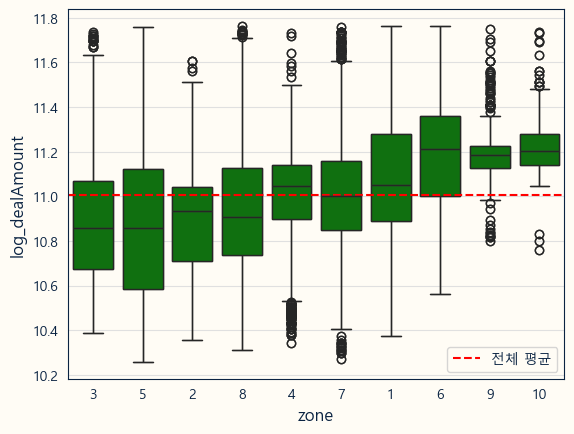

In [ ]:
# zone별 평균 정렬
order = df.groupby('zone')['log_dealAmount'].mean().sort_values().index

# 평균 매매가 기준으로 zone을 정렬
sns.boxplot(x='zone', y='log_dealAmount', data=df, order=order)

# 평균선 추가
mean_val = df['log_dealAmount'].mean()

sns.boxplot(x='zone', y='log_dealAmount', data=df, order=order,color='green')
plt.axhline(mean_val, color='red', linestyle='--', label='전체 평균')
plt.legend()


#### 매매 가격을 순서 정렬하여 평균선 추가
- 전체 평균선(빨간선)보다 높은 zone: 6, 9, 10
- 평균보다 낮은 zone: 2, 3, 5
- 활용: 향후 클러스터링이나 입지 점수 평가 시 기준점으로 활용 가능. 혹은 단순 회귀식이 아닌 입지 효과 계량화 지표로 쓰기 좋음.

In [ ]:
df.to_csv('rename_final_df.csv',index=False, encoding='utf-8')
df.to_csv('rename_final_df_sig.csv',index=False, encoding='utf-8-sig')